In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [14]:
from scipy.stats import mode

#It returns an array of the modal (most common) value in the passed array.


In [15]:
#first of all we will be building a class of node with the following arguments
class Node:
    def __init__(n, featureName, featureColNum,condition):
        '''
        __init__ is a reseved method in python classes. 
        It is known as a constructor in object oriented concepts. This method called when
        an object is created from the class and it allow the class 
        to initialize the attributes of a class.
        '''
        n.featureName = featureName
        n.featureColNum = featureColNum
        n.condition= condition
        n.leftNode = None
        n.rightNode = None
        n.className = None
        n.classified_in = -1
        
        # n represents the same object or instance of the class.
        # on internet, 'self' is more commonly used instead. but since n worked, so I didn't change

In [16]:
# lets calculate entropy of node first
def entropy(dataset):
    Count = [] # count stores the total number of classes
    Entropy = 0.0 #entropy is initially zero
    for Class in targetClasses: #if there's a class in the target then count will be updated
        Count.append(len(dataset[dataset[targetColNum] == Class]))
    #using formula of entropy:-
    totalClasses = float(len(dataset))
    for c in Count:
        if c != 0: 
            Entropy += (-1) * (c/totalClasses) * np.log2(c/totalClasses)
    return Entropy #entropy is returned

In [17]:
# now calculate info gain. this function will also use values of entropy function
def informationGain(dataset, alreadyVisitedClass):
    rootEntropy = entropy(dataset)
    datasetMedian = np.median(dataset, axis=0)
    entropy1 = [] 
    for colNum in range(numCols):
        if (not alreadyVisitedClass[colNum]) and (len(dataset)) > 0:
            Entropy = (len(dataset[(dataset[colNum] < datasetMedian[colNum])])/float(len(dataset))) * entropy(dataset[(dataset[colNum] < datasetMedian[colNum])]) + (len(dataset[(dataset[colNum] >= datasetMedian[colNum])])/float(len(dataset))) * entropy(dataset[(dataset[colNum] >= datasetMedian[colNum])])
        entropy1.append(Entropy)
        
    #using info gain formula
    InformationGain = np.array(rootEntropy) - entropy1
    return InformationGain, np.argmax(InformationGain), datasetMedian[np.argmax(InformationGain)]

In [18]:
# a function to derive all the useful information out of the dataset
def Dataset(sourceDataset):
    resultDataset = []
    dataframe = pd.DataFrame(sourceDataset.data)
    m,n = dataframe.shape
    for i in range(n):
        resultDataset.append(dataframe[i])
    resultDataset.append(pd.DataFrame(sourceDataset.target)[0])
        
    resultDataset = pd.DataFrame(np.array(resultDataset).T)
    m,n = resultDataset.shape
    return resultDataset, m, n-1, n-1, sourceDataset.feature_names, sourceDataset.target_names

In [19]:
# let's obtain all features
#first, initialize to default then define the function initialize
numRows = -1
numCols = -1
targetClasses = -1
targetColNum = -1
featureNames = []
classNames = []
def initilize(dataset):
    global numRows, numCols, targetClasses, targetColNum, featureNames, classNames
    dataset, numRows,numCols, targetColNum, featureNames, classNames = Dataset(dataset)
    # function dataset is called in the above line
    targetClasses = np.array(dataset[targetColNum].unique())    #all unique target values are obtained
    return dataset

In [20]:
# this decision function is used to segregate the data according to condition
# it will tell us that in which side of node the data will go, the concept used is like labels given to us in basefile 
def makeDecision(data, decisionTree):
    while True:
        if data[decisionTree.featureColNum] < decisionTree.condition:
            decisionTree = decisionTree.leftNode
        else:
            decisionTree = decisionTree.rightNode
        
        if decisionTree.className is not None:
            break  
    return decisionTree.classified_in

In [21]:
#this function is self-explanatory
def makeDecisionTree(dataset, decisionNode, visitedClasses):
    if visitedClasses is None:
        visitedClasses = np.repeat(False, numCols)
    
    information_gain, featureColNum, info = informationGain(dataset, visitedClasses)
    visitedClasses[featureColNum] = True
    
    decisionNode = Node(featureNames[featureColNum], featureColNum, info)
    
    
    if visitedClasses.all() or (len(np.array(dataset[targetColNum].unique())) <= 1):
        if len(dataset[0]) > 0:
            decisionNode.className = classNames[int(mode(dataset[targetColNum]).mode)]
            decisionNode.classified_in = int(mode(dataset[targetColNum]).mode)
    else:
        splitData_True  = dataset[(dataset[featureColNum] < info)]
        splitData_False = dataset[(dataset[featureColNum] >= info)]
        
        decisionNode.leftNode = makeDecisionTree(splitData_True, decisionNode, np.array(visitedClasses))
        decisionNode.rightNode = makeDecisionTree(splitData_False, decisionNode, np.array(visitedClasses))
        
    return decisionNode

In [22]:
from PIL import Image,ImageDraw
from IPython.core.display import Image as I, display 


def getTreeWidth(tree):
    if tree.className is None:
        width = getTreeWidth(tree.leftNode) + getTreeWidth(tree.rightNode)
    else:
        return 1
    return width
        

def drawtree(tree,jpeg='tree.jpg'):
    w= getTreeWidth(tree)*100+ 70
    h= getTreeWidth(tree)*70

    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)
    drawnode(draw,tree,w/2,20)
    img.save(jpeg,'JPEG')
    display(I('tree.jpg', width=900, unconfined=True))


def drawnode(draw,tree,x,y):
    if tree.className==None:
        # Get the width of each branch
        w1=getTreeWidth(tree.leftNode)*100
        w2=getTreeWidth(tree.rightNode)*100

        # Determine the total space required by this node
        left=x-(w1+w2)/2
        right=x+(w1+w2)/2

        # Draw the condition string
        draw.text((x-20,y-10),str(tree.featureName) + '[' + str(tree.featureColNum)+'] < '+str(tree.condition)+'? ',(0,0,0))
        # Draw links to the branches
        draw.line((x,y,left+w1/2,y+100),fill=(0,255,0))
        draw.line((x,y,right-w2/2,y+100),fill=(0,255,0))
    
        # Draw the branch nodes
        drawnode(draw,tree.leftNode,left+w1/2,y+100)
        drawnode(draw,tree.rightNode,right-w2/2,y+100)
    else:
        txt= str(tree.className) + '[' + str(tree.classified_in) + ']'
        draw.text((x-20,y),txt,(0,0,0))

In [23]:
from sklearn.datasets import load_iris
irisDataset = load_iris()

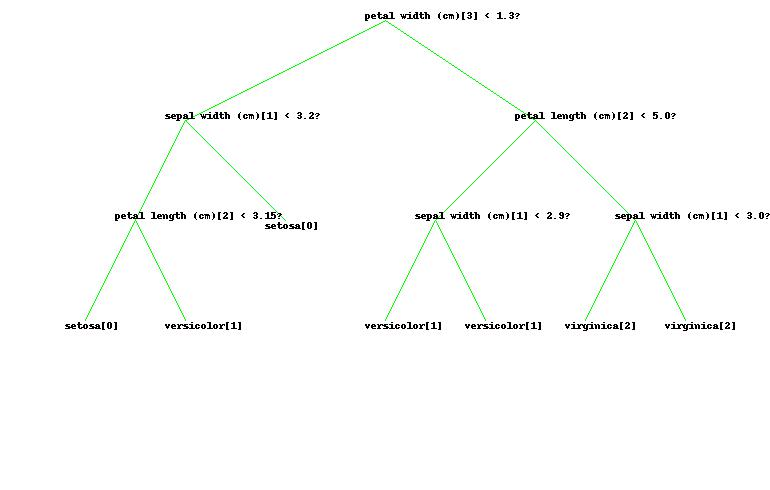

In [24]:

d = initilize(irisDataset)
#ansTree is the Resulatant Tree as a Decision Tree Root Node, with Full Connectivity.
ansTree = makeDecisionTree(d, None, None)
drawtree(ansTree)